In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# csv should be in raw view
url = 'https://raw.githubusercontent.com/neelabhpant/Deep-Learning-in-Python/master/USD_INR.csv'
df = pd.read_csv(url)
df.head()

,Date,Price,Open,High,Low,Change %
0,"Aug 10, 2017",64.165,63.898,64.175,63.855,0.48
1,"Aug 09, 2017",63.860,63.780,63.860,63.710,0.26
2,"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23
3,"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
4,"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05


In [5]:
#df = pd.read_csv('USD_INR.csv')
df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)
df_idx.head(5)

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


In [0]:
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]

In [7]:
df_idx.head(5)

,Change %,High,Low,Open,Price
Date,,,,,
1980-01-02,0.00,8.00,8.00,8.00,8.00
1980-01-03,-0.63,7.95,7.95,7.95,7.95
1980-01-04,1.26,8.05,8.05,8.05,8.05
1980-01-07,0.00,8.05,8.05,8.05,8.05
1980-01-08,0.00,8.05,8.05,8.05,8.05


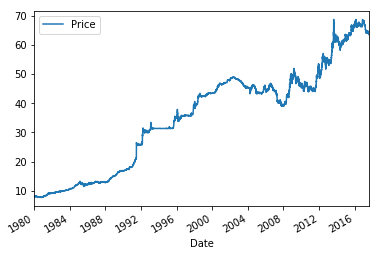

In [8]:
data = df_idx[['Price']]
data.plot(y='Price')

In [9]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1980 to %d"%(1980 + int(0.8*years)))

Total data: 37 years
80 percent data = 1980 to 2009


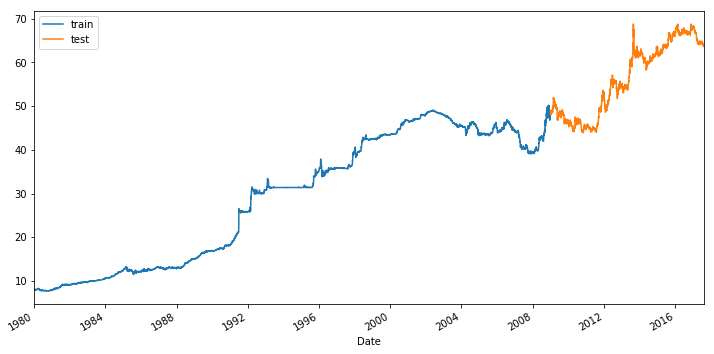

In [11]:
split_date = pd.Timestamp('01-01-2009')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(12,6))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)


In [13]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))


Train size: (7451 x 1)
Test size: (2245 x 1)


### Training a baseline model SVM regressor

In [0]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [19]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


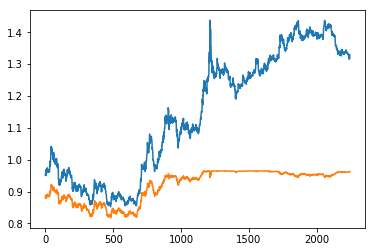

In [20]:
plt.plot(y_test)
plt.plot(y_pred)

In [21]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -0.963381


In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


In [23]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
7451/7451 [==============================] - 1s 122us/step - loss: 0.0110
Epoch 2/20
7451/7451 [==============================] - 0s 50us/step - loss: 0.0041
Epoch 3/20
7451/7451 [==============================] - 0s 47us/step - loss: 0.0027
Epoch 4/20
7451/7451 [==============================] - 0s 48us/step - loss: 0.0025
Epoch 5/20
7451/7451 [==============================] - 0s 46us/step - loss: 0.0024
Epoch 6/20
7451/7451 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 7/20
7451/7451 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 8/20
7451/7451 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 9/20
7451/7451 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 10/20
7451/7451 [==============================] - 0s 45us/step - loss: 0.0024
Epoch 11/20
7451/7451 [===============

R-Squared: -1.163679


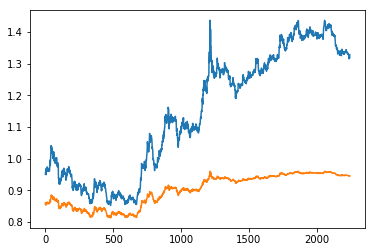

In [24]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

In [25]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 1s 94us/step - loss: 0.0055
Epoch 2/20
7451/7451 [==============================] - 1s 72us/step - loss: 1.0905e-05
Epoch 3/20
7451/7451 [==============================] - 0s 65us/step - loss: 1.0322e-05
Epoch 4/20
7451/7451 [==============================] - 0s 58us/step - loss: 1.1510e-05
Epoch 5/20
7451/7451 [==============================] - 0s 60us/step - loss: 1.2637e-05
Epoch 6/20
7451/7451 [==============================] - 0s 59us/step - loss: 1.4207e-05
Epoch 7/20
7451/7451 [==============================] - 0s 58us/step - loss: 1.4394e-05
Epoch 8/20
7451/7451 [==============================] - 0s 58us/step - loss: 1.5755e-05
Epoch 9/20
7451/7451 [==============================] - 0s 58us/step - loss: 1.7001e-05
Epoch 10/20
7451/7451 [==============================] - 0s 58us/step - loss: 1.8387e-05
Epoch 11/20
7451/7451 [==============================] - 0s 58us/step - loss: 2.5317e-05
Epoch 12/20
7451/7451 [===========

R-Squared: 0.998799


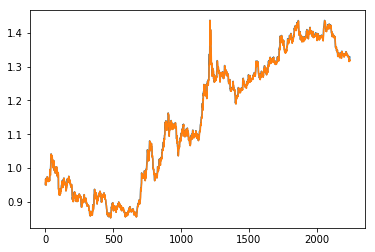

In [26]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

In [29]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
7451/7451 [==============================] - 0s 65us/step - loss: 0.0029
Epoch 2/10
7451/7451 [==============================] - 0s 35us/step - loss: 9.2119e-06
Epoch 3/10
7451/7451 [==============================] - 0s 40us/step - loss: 9.6531e-06
Epoch 4/10
7451/7451 [==============================] - 0s 38us/step - loss: 8.9669e-06
Epoch 5/10
7451/7451 [==============================] - 0s 37us/step - loss: 9.5424e-06
Epoch 6/10
7451/7451 [==============================] - 0s 35us/step - loss: 1.0689e-05
Epoch 7/10
7451/7451 [==============================] - 0s 33us/step - loss: 9.3326e-06
Epoch 8/10
7451/7451 [==============================] - 0s 33us/step - loss: 1.0748e-05
Epoch 9/10
7451/7451 [==============================] - 0s 35us/step - loss: 1.0733e-05
Epoch 10/10
7451/7451 [==============================] - 0s 33us/step - loss: 1.0463e-05


R-Squared: 0.998799


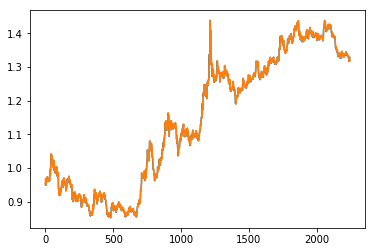

In [31]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))